<a href="https://www.kaggle.com/code/nadaaglan/image-segmentation-on-a-custom-dataset?scriptVersionId=180562487" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image, ImageDraw
import json
import cv2
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dental-periapical-x-rays/README.dataset.txt
/kaggle/input/dental-periapical-x-rays/README.roboflow.txt
/kaggle/input/dental-periapical-x-rays/valid/Primary-Endo-with-Secondary-Perio-122-_JPG.rf.872a75742fa9c3ff22aa02720c7eb1f9.jpg
/kaggle/input/dental-periapical-x-rays/valid/-1041-_png.rf.3b06b31825b6d3f85c20bcd799fd9650.jpg
/kaggle/input/dental-periapical-x-rays/valid/True-Combined-Lesions-7-_JPG.rf.842732cf4c2d70345363b0198035300d.jpg
/kaggle/input/dental-periapical-x-rays/valid/OIP-11-_jpg.rf.5d82c49963104523681e85a6af274359.jpg
/kaggle/input/dental-periapical-x-rays/valid/13_jpeg.rf.7cd03b74e48c64eeedb38b926030e744.jpg
/kaggle/input/dental-periapical-x-rays/valid/-94-_jpg.rf.3e4553b8a6505e400cece3b0d31d7f8a.jpg
/kaggle/input/dental-periapical-x-rays/valid/True-Combined-Lesions-45-_JPG.rf.2bb9bead9780cde63acab7187fab8e16.jpg
/kaggle/input/dental-periapical-x-rays/valid/-1050-_png.rf.d991e69ae2874a0946e4db82e4f5132b.jpg
/kaggle/input/dental-periapical-x-rays/valid/48_jp

# Binary Mask Creation Function

In [2]:
def create_mask(width, height, polygon):
    mask = Image.new('L', (width, height), 0)
    draw = ImageDraw.Draw(mask)

    # Convert segmentation points to tuples of integers
    polygon_points = [(int(polygon[i]), int(polygon[i+1])) for i in range(0, len(polygon), 2)]

    draw.polygon(polygon_points, outline=1, fill=1)
    mask_array = np.array(mask)
    return mask_array

# Extracting Images Mask Info


In [3]:
def load_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Extract mask information
def extract_masks(data):
    mask_data = []
    
    # Extract categories
    categories = {category['id']: category['name'] for category in data['categories']}
    
    # Extract annotations
    for annotation in data['annotations']:
        image_id = annotation['image_id']
        category_id = annotation['category_id']
        segmentation = annotation['segmentation']
        # Add more attributes as needed
        
        # Now you can process the annotation data as required
        
        # Append annotation data to list
        mask_data.append({
            'image_id': image_id,
            'category_id': category_id,
            'segmentation': segmentation,
            # Add more attributes as needed
        })
    
    return mask_data

# Displaying some of the Extracted Masks

In [4]:
def print_mask_details(json_file_path, limit=5):
    # Load JSON data
    data = load_json(json_file_path)
    
    # Extract mask data
    mask_data = extract_masks(data)
    
    # Print the number of masks extracted
    print("Number of masks extracted:", len(mask_data))
    
    # Print details about each mask, limiting to the specified number of results
    for i, mask_info in enumerate(mask_data[:limit]):
        print(f"\nMask {i+1}:")
        print("Image ID:", mask_info['image_id'])
        print("Category ID:", mask_info['category_id'])
        print("Segmentation:", mask_info['segmentation'])


# Visulaizing the Extracted Masks Vs. The Original Images

In [5]:
def visualize_masks(data, mask_data, folder_path):
    for image_info in data['images'][:5]:  # Iterate over the first 5 images
        image_id = image_info['id']
        image_filename = image_info['file_name']
        image_path = os.path.join(folder_path, image_filename)
        annotations = [anno for anno in mask_data if anno['image_id'] == image_id]

        # Load image
        image = plt.imread(image_path)
        plt.imshow(image)
        
        # Plot masks
        for annotation in annotations:
            segmentation = annotation['segmentation']
            for seg_points in segmentation:
                seg_points = [seg_points[i:i+2] for i in range(0, len(seg_points), 2)]
                seg_points.append(seg_points[0])  
                seg_points = [[point[0], point[1]] for point in seg_points]
                seg_points = list(zip(*seg_points))
                plt.plot(seg_points[0], seg_points[1], color='green', linewidth=1)
        
        plt.title(f"Image {image_id} with Masks")
        plt.axis('off')
        plt.show()

# Segmentation and CSV File Creation

In [21]:
import os
import json
import numpy as np
import cv2
from PIL import Image, ImageDraw
import pandas as pd

def create_segmented_dataset(data, mask_data, folder_path, save_path, target_size=(224, 224)):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # Initialize a list to store the image paths and labels
    data_rows = []

    # Create a dictionary to map category IDs to category names
    category_mapping = {category['id']: category['name'] for category in data['categories']}

    for image_info in data['images']:
        image_id = image_info['id']
        image_filename = image_info['file_name']
        image_path = os.path.join(folder_path, image_filename)
        annotations = [anno for anno in mask_data if anno['image_id'] == image_id]

        # Load image
        image = Image.open(image_path)
        image_array = np.array(image)

        # Segment image using masks
        for annotation in annotations:
            segmentation = annotation['segmentation']
            category_id = annotation['category_id']
            category_name = category_mapping.get(category_id, 'Unknown')

            # Create a separate segmented image for each annotation
            segmented_image = np.zeros_like(image_array)

            for seg_points in segmentation:
                seg_points = [seg_points[i:i+2] for i in range(0, len(seg_points), 2)]
                seg_points = [[int(point[0]), int(point[1])] for point in seg_points]
                seg_mask = np.zeros_like(image_array, dtype=np.uint8)
                cv2.fillPoly(seg_mask, [np.array(seg_points)], (255, 255, 255))
                annotated_image = np.where(seg_mask == 255, image_array, 0)

                # Save segmented image
                segmented_image_path = os.path.join(save_path, f"{image_id}_{category_name}_{len(data_rows)}.jpg")
                segmented_image_pil = Image.fromarray(annotated_image.astype(np.uint8))
                segmented_image_pil.save(segmented_image_path)

                # Resize the image
                resized_image = segmented_image_pil.resize(target_size, Image.ANTIALIAS)
                resized_image.save(segmented_image_path)  # Overwrite the original image with resized one

                # Append image path and label to the list
                data_rows.append([segmented_image_path, category_name])

    # Create DataFrame from the list of image paths and labels
    df = pd.DataFrame(data_rows, columns=['Image_Path', 'Label'])

    # Save DataFrame to CSV file
    csv_path = os.path.join(save_path, 'segmented_images.csv')
    df.to_csv(csv_path, index=False)

    print("Segmented images and CSV file created successfully.")


In [7]:
def display_segmented_images(segmented_images_dir, num_images=5):
    # Get list of segmented image files
    segmented_image_files = os.listdir(segmented_images_dir)

    # Set figure size for larger images
    plt.figure(figsize=(15, 5))

    # Display the specified number of images
    for i in range(min(num_images, len(segmented_image_files))):
        image_path = os.path.join(segmented_images_dir, segmented_image_files[i])
        image = plt.imread(image_path)

        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()

# Testing Data

In [8]:
json_file_path = "/kaggle/input/my-dataset/test/_annotations.coco.json"  # Update with actual file path
data = load_json(json_file_path)
mask_data = extract_masks(data)
print_mask_details(json_file_path, limit=5)

Number of masks extracted: 77

Mask 1:
Image ID: 0
Category ID: 3
Segmentation: [[590.715, 265.753, 619.376, 122.289, 581.47, 61.317, 489.941, 88.814, 433.544, 69.686, 363.28, 101.965, 353.924, 152.68, 386.393, 249.015, 461.28, 266.948, 507.507, 276.512, 524.149, 240.647, 572.225, 280.099, 590.715, 265.753]]

Mask 2:
Image ID: 1
Category ID: 6
Segmentation: [[441.397, 210.754, 478.572, 221.586, 489.724, 210.077, 497.159, 176.903, 450.691, 179.611, 410.728, 171.487, 395.858, 157.27, 348.804, 125.379, 324.296, 190.444, 340.096, 220.909, 383.776, 212.785, 411.657, 206.692, 441.397, 210.754]]

Mask 3:
Image ID: 2
Category ID: 2
Segmentation: [[348.278, 201.399, 327.041, 158.542, 247.273, 143.248, 240.244, 157.352, 227.317, 239.495, 276.255, 257.352, 328.887, 241.875, 348.278, 201.399]]

Mask 4:
Image ID: 3
Category ID: 2
Segmentation: [[438.557, 268.475, 427.041, 237.391, 387.261, 254.96, 349.71, 236.999, 304.559, 253.609, 291.996, 303.613, 353.761, 341.454, 378.886, 365.781, 432.276, 323.

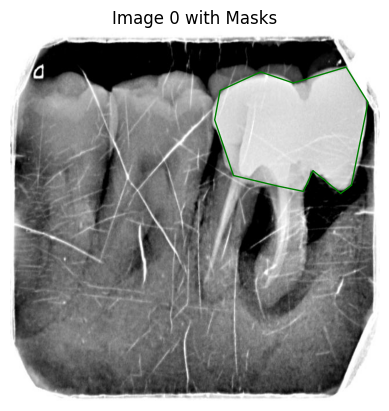

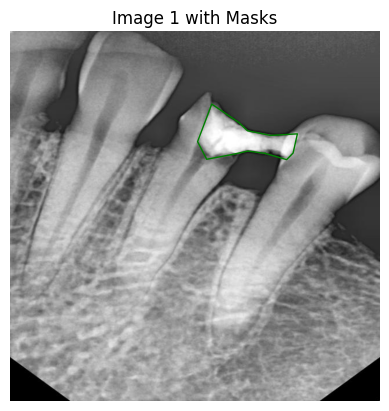

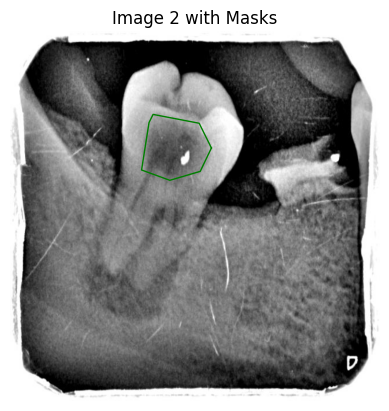

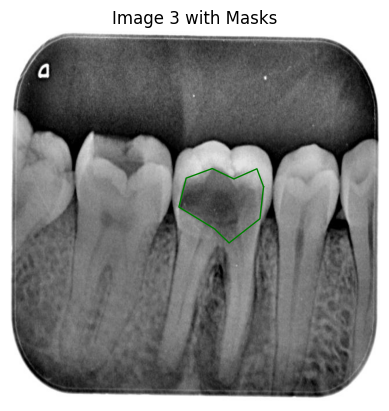

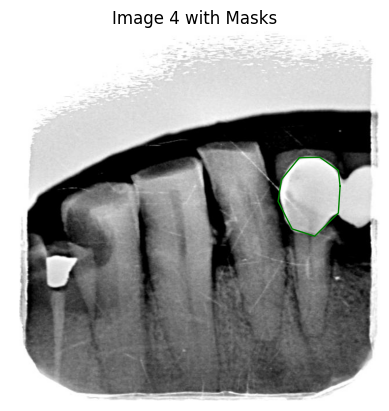

In [9]:
# Visualize masks overlaid on images for the first 5 images only
folder_path = '/kaggle/input/dental-periapical-x-rays/test'
visualize_masks(data, mask_data, folder_path)


In [22]:
# Example usage
json_file_path = "/kaggle/input/dental-periapical-x-rays/test/_annotations.coco.json"  # Update with actual file path
folder_path = '/kaggle/input/dental-periapical-x-rays/test'
save_path = '/kaggle/working/test_segmented_images'
data = load_json(json_file_path)
mask_data = extract_masks(data)
create_segmented_dataset(data, mask_data, folder_path, save_path)

/tmp/ipykernel_34/85356347.py:51: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = segmented_image_pil.resize(target_size, Image.ANTIALIAS)


Segmented images and CSV file created successfully.


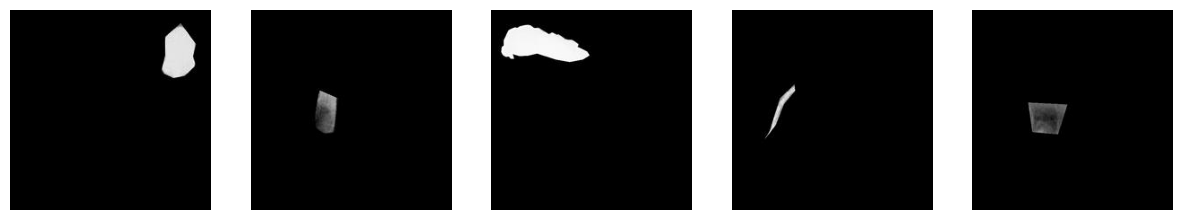

In [23]:
segmented_images_dir = "/kaggle/working/test_segmented_images"
display_segmented_images(segmented_images_dir)

# Validation Data

In [12]:
json_file_path = "/kaggle/input/dental-periapical-x-rays/valid/_annotations.coco.json"  # Update with actual file path
data = load_json(json_file_path)
mask_data = extract_masks(data)
print_mask_details(json_file_path, limit=5)

Number of masks extracted: 157

Mask 1:
Image ID: 0
Category ID: 4
Segmentation: [[357.793, 580.203, 415.777, 612.212, 457.194, 640, 530.364, 623.215, 566.259, 567.199, 526.223, 506.181, 504.133, 446.163, 475.141, 225.097, 415.777, 249.104, 392.307, 293.117, 390.927, 413.153, 372.979, 465.168, 350.89, 501.179, 357.793, 580.203]]

Mask 2:
Image ID: 0
Category ID: 2
Segmentation: [[172.797, 582.203, 201.789, 640, 248.728, 633.218, 222.999, 519, 172.797, 582.203]]

Mask 3:
Image ID: 1
Category ID: 5
Segmentation: [[282.606, 300.268, 290.605, 241.803, 313.001, 239.465, 378.59, 223.095, 375.391, 144.752, 386.589, 186.847, 416.984, 310.792, 447.379, 410.182, 412.184, 211.402, 397.787, 137.736, 348.4, 46.174, 319.4, 48.869, 352.994, 119.027, 364.192, 214.91, 287.405, 235.957, 282.606, 300.268]]

Mask 4:
Image ID: 2
Category ID: 5
Segmentation: [[455.377, 299.099, 464.976, 97.98, 439.38, 200.878, 412.184, 409.013, 470.4, 408.548, 455.377, 299.099]]

Mask 5:
Image ID: 3
Category ID: 4
Segmentat

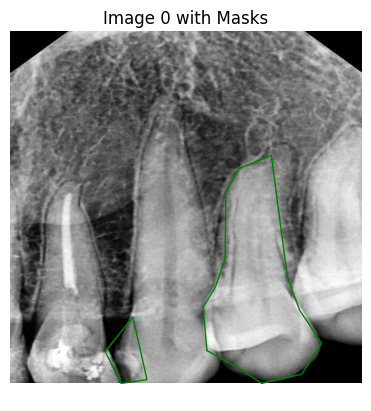

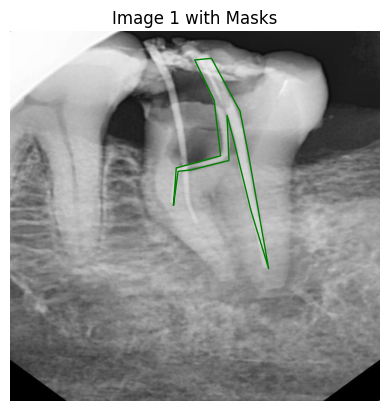

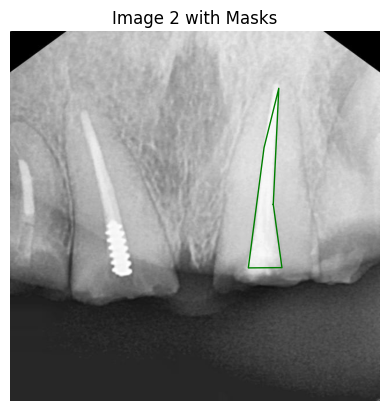

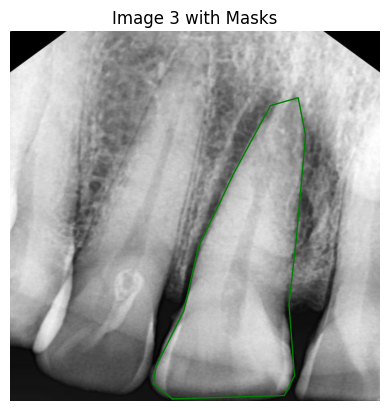

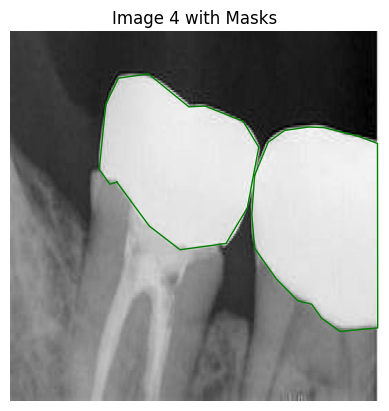

In [13]:
# Update the folder path to point to the validation images folder
folder_path = '/kaggle/input/dental-periapical-x-rays/valid'

# Visualize masks overlaid on validation images for the first 5 images only
visualize_masks(data, mask_data, folder_path)


In [24]:
# Example usage
json_file_path = "/kaggle/input/dental-periapical-x-rays/valid/_annotations.coco.json"  # Update with actual file path
folder_path = '/kaggle/input/dental-periapical-x-rays/valid'
save_path = '/kaggle/working/valid_segmented_images'
data = load_json(json_file_path)
mask_data = extract_masks(data)
create_segmented_dataset(data, mask_data, folder_path, save_path)

/tmp/ipykernel_34/85356347.py:51: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = segmented_image_pil.resize(target_size, Image.ANTIALIAS)


Segmented images and CSV file created successfully.


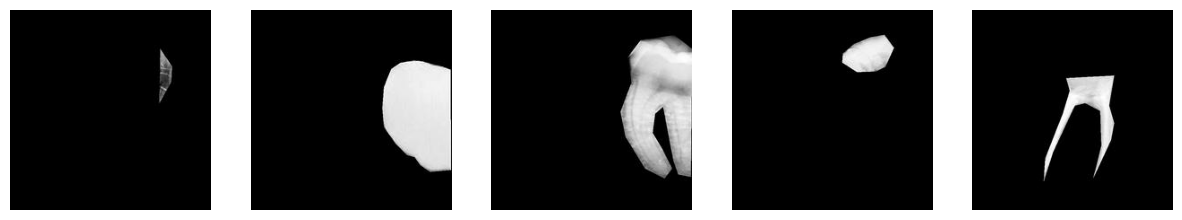

In [25]:
segmented_images_dir = "/kaggle/working/valid_segmented_images"
display_segmented_images(segmented_images_dir)

# Training Data

In [26]:
json_file_path = "/kaggle/input/dental-periapical-x-rays/train/_annotations.coco.json"  # Update with actual file path
data = load_json(json_file_path)
mask_data = extract_masks(data)
print_mask_details(json_file_path, limit=5)

Number of masks extracted: 2761

Mask 1:
Image ID: 0
Category ID: 6
Segmentation: [[406.976, 284.147, 418.449, 272.29, 415.984, 227.68, 334.87, 152.774, 306.563, 176.027, 290.244, 273.665, 290.792, 365.298, 248.704, 427.975, 251.335, 454.31, 275.382, 477.105, 337.974, 465.098, 399.982, 424.446, 408.891, 328.655, 406.976, 284.147]]

Mask 2:
Image ID: 1
Category ID: 5
Segmentation: [[348.446, 269.242, 374.904, 196.677, 320.533, 186.671, 294.835, 194.866, 190.555, 206.1, 104.832, 229.041, 107.148, 254.352, 162.055, 251.124, 227.473, 266.48, 303.879, 271.677, 348.446, 269.242]]

Mask 3:
Image ID: 2
Category ID: 4
Segmentation: [[247.862, 483.524, 276.479, 483.524, 290.787, 414.001, 290.787, 369.97, 343.25, 341.002, 362.328, 398.938, 363.918, 505.54, 394.124, 532.19, 433.869, 511.333, 454.536, 390.827, 454.536, 332.891, 499.051, 268.003, 529.257, 228.606, 486.332, 172.988, 414.791, 161.401, 357.559, 131.274, 298.534, 120.471, 243.093, 150.973, 227.195, 184.575, 241.503, 248.305, 227.195, 33

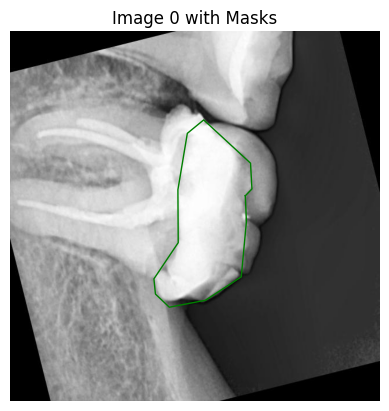

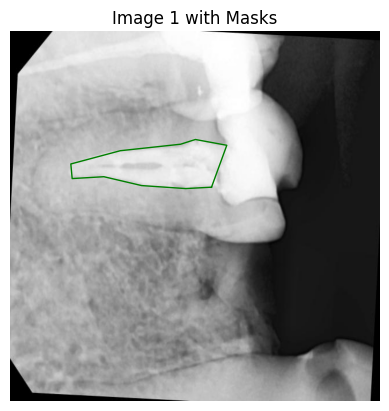

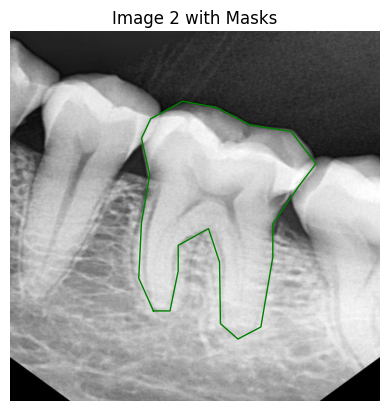

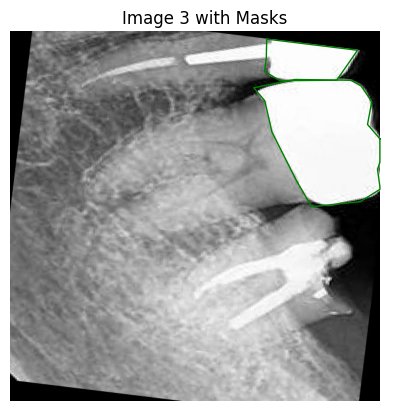

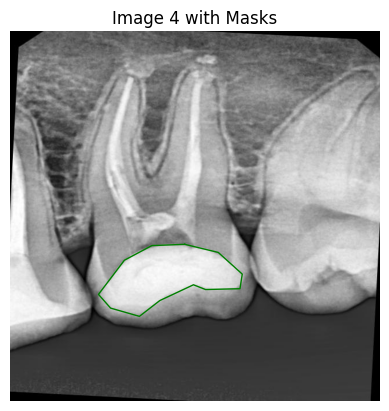

In [17]:
train_folder_path = "/kaggle/input/dental-periapical-x-rays/train"
visualize_masks(data, mask_data, train_folder_path)

In [27]:
# Example usage
json_file_path = "/kaggle/input/dental-periapical-x-rays/train/_annotations.coco.json"  # Update with actual file path
folder_path = '/kaggle/input/dental-periapical-x-rays/train'
save_path = '/kaggle/working/train_segmented_images'
data = load_json(json_file_path)
mask_data = extract_masks(data)
create_segmented_dataset(data, mask_data, folder_path, save_path)

/tmp/ipykernel_34/85356347.py:51: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = segmented_image_pil.resize(target_size, Image.ANTIALIAS)


Segmented images and CSV file created successfully.


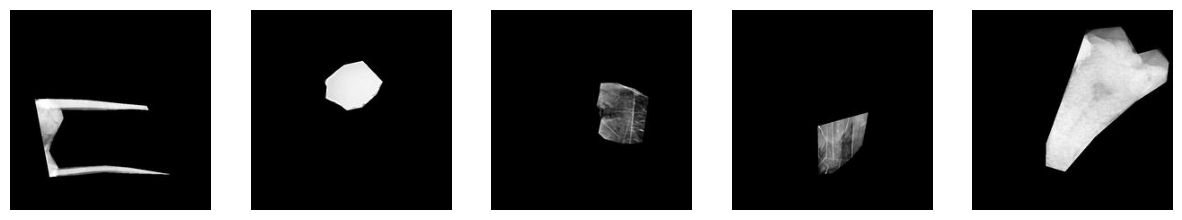

In [28]:
segmented_images_dir = "/kaggle/working/train_segmented_images"
display_segmented_images(segmented_images_dir)